In [42]:
import numpy as np
import matplotlib.pyplot as plt


def load_from_csv(file):
    """file: filename
       return: 
           features: np.array[ncases, nfeatures]
           descriptions: list[nfeatures]
           correct_answers: np.array[ncases]
    """
    raw_data = np.genfromtxt(file, delimiter=',', names=True, dtype=int)
    raw_descriptions = list(raw_data.dtype.names)
    raw_data = np.array(list(map(list, raw_data)))
    
    features = raw_data[:, 1:-1]
    descriptions = raw_descriptions[1:-1]
    correct_answers = raw_data[:,-1]  
    return features, descriptions, correct_answers


def save_to_csv(descriptions, features, correct_answers, file):
    """descriptions: list[nfeatures]
       features: np.array[ncases, nfeatures]
       correct_answers: np.array[ncases]
       file: filename
    """
    f = open(file, 'wt')
    descriptions = ["ID"] + descriptions + ["default.payment.next.month"]
    print(','.join(descriptions), file=f)
    for i in range(features.shape[0]):
        print("%i,%s,%f" % (i+1, ','.join(map(str, features[i])), correct_answers[i]), file=f)
    f.close()
 
    
def add_feature(features, descriptions, new_feature, new_description):
    """
        features: np.array[ncases, nfeatures]
        descriptions: list[nfeatures]
        new_feature: np.array[ncases]
        new_description: str
        return:
            new_features: np.array[ncases, nfeatures+1]
            new_descriptions: list[nfeatures+1]
            
    """
    new_features, new_descriptions = add_features(features, descriptions, new_feature[:,np.newaxis], [new_description])
    return new_features, new_descriptions


def add_features(features, descriptions, new_features, new_descriptions):
    """
        features: np.array[ncases, nfeatures]
        descriptions: list[nfeatures]
        new_features: np.array[ncases, nnewfeatures]
        new_descriptions: list[nnewfeatures]
        return:
            new_new_features: np.array[ncases, nfeatures+nnewfeatures]
            new_new_descriptions: list[nfeatures+nnewfeatures]
    """
    new_new_features = np.concatenate([features, new_features],1)
    new_new_descriptions = descriptions + new_descriptions
    return new_new_features, new_new_descriptions
    
def add_one_hot_encoded_feature(features, descriptions, feature, description):
    """
        features: np.array[ncases, nfeatures]
        descriptions: list[nfeatures]
        feature: np.array[ncases]
        description: str
        return:
            new_features: np.array[ncases, nfeatures+1]
            new_descriptions: list[nfeatures+1]
    """
    hot_features, hot_descriptions = one_hot_encoded_feature(feature, description)
    new_features = np.concatenate([features, hot_features], 1)
    new_descriptions = descriptions + hot_descriptions
    return new_features, new_descriptions

def one_hot_encoded_feature(feature, description):
    """
        feature: np.array[ncases]
        description: str
        return:
            new_features: np.array[ncases,n_one_hot_encoded_features]
            new_descriptions: list[n_one_hot_encoded_features]
    """
    unique_values = sorted(set(feature)) #сколько столбцов
    new_descriptions = []
    for i in range(len(unique_values)):
        new_descriptions.append(description + " = " + str(unique_values[i]))
    feature = feature[:,np.newaxis]
    unique_values = np.array(unique_values)
    unique_values = unique_values[np.newaxis,:]      
    return (feature == unique_values), new_descriptions

def make_uniform_borders(feature, c_diapasones):
    """
    feature: np.array[ncases]
    c_diapasones: int
    return:
        uniform_borders: list[c_diapasones-1]
    """
    max_diap = np.max(feature)
    min_diap = np.min(feature)
    diap = max_diap - min_diap
    step = diap / c_diapasones##20
    uniform_borders=[]
    for i in range(1, c_diapasones):
        uniform_borders.append(min_diap + step * i)   
    return uniform_borders

def make_quantile_borders(feature, c_diapasones):
    """
    feature: np.array[ncases]
    c_diapasones: int
    return:
        quantile_borders: list[c_diapasones-1]
    """
    quantile_numbers = make_uniform_borders([0, 1], c_diapasones)
    feature = sorted(feature)
    quantile_borders = []
    for i in range(0, c_diapasones - 1):
        quantile_borders.append(get_quantile_element(feature, quantile_numbers[i]))
    return quantile_borders

def get_quantile_element(sorted_feature, quantile_number):
    """
    sorted_feature: sorted list[ncases]
    quantile_number: int
    return:
        quantile_element: int
    """
    return sorted_feature[int(quantile_number * len(sorted_feature))]
    
def quantificator(feature, description, borders):
    """
    feature: np.array[ncases]
    description: str
    borders: list[nborders]
    return:
        new_features: np.array[ncases,nborders+1]
        new_descriptions: list[nborders+1]
    """
    borders = sorted(borders)
    f1 = feature < borders[0]
    d1 = description + " < %f" %borders[0]
    
    fi = []
    di = []
    for i in range(0, len(borders)-1):
        fi.append(np.logical_and(feature >= borders[i], feature < borders[i+1]))
        di.append(("%f <="%borders[i]) + description + " < %f" %borders[i+1])
    flast = feature >= borders[-1]
    dlast = ("%f <="%borders[-1]) + description
    
    new_features = np.stack([f1] + fi + [flast], axis=1)
    new_descriptions = [d1] + di + [dlast]
    
    return new_features.astype(np.float32), new_descriptions

def add_qr_feature(features, descriptions, feature, description, c_diapasones):
    """
    features: np.array[ncases, nfeatures]
    descriptions: list[nfeatures]
    feature: np.array[ncases]
    description: str
    c_diapasones: int
    return:
        new_features: np.array[ncases,2*c_diapasones-1]
        new_descriptions: list[2*c_diapasones-1]
    
    """
    uniform_borders = []#make_uniform_borders(feature, c_diapasones)
    quantile_borders = make_quantile_borders(feature, c_diapasones)
    all_borders = uniform_borders + quantile_borders
    new_features, new_descriptions = quantificator(feature, description, all_borders)  
    new_features, new_descriptions = add_features(features, descriptions, new_features, new_descriptions)
    return new_features, new_descriptions

def analyze(features, descriptions):
    std_dev = np.apply_along_axis(np.std, 0, features)
    mean = np.apply_along_axis(np.mean, 0, features)
    for i in range(features.shape[1]):
        print('%r:======================================================================' %(i))
        print(descriptions[i])
        print("std_dev", std_dev[i])
        print("mean", mean[i])
        print("min", np.min(features[:,i]))
        print("max", np.max(features[:,i]))
        n, bins, patches = plt.hist(features[:,i], 20, normed=0, facecolor='red',)
        plt.show()

LIMIT_BAL = 0
SEX = 1
EDUCATION = 2
MARRIAGE = 3
AGE = 4
PAY_0 = 5 
PAY_2 = 6 
PAY_3 = 7
PAY_4 = 8
PAY_5 = 9
PAY_6 = 10
BILL_AMT1 = 11
BILL_AMT2 = 12
BILL_AMT3 = 13
BILL_AMT4 = 14
BILL_AMT5 = 15
BILL_AMT6 = 16
PAY_AMT1 = 17
PAY_AMT2 = 18
PAY_AMT3 = 19
PAY_AMT4 = 20
PAY_AMT5 = 21
PAY_AMT6 = 22

In [49]:
np.set_printoptions(300000)
features, descriptions, correct_answers = load_from_csv('ccard_dev.csv')

# Feature 0.
nf = np.ones((features.shape[0], 1))
nd = ["1"]

# Feature 1.
f = features[:,LIMIT_BAL]
f = np.log(f)
print(np.min(f))

a = f - np.min(f)
b = max(f) - np.min(f)
print(a, b)
f = a / b
print(f)
nf, nd = add_feature(nf, nd, f, "LOG(%s)"%descriptions[LIMIT_BAL])

print(nf)

# # Feature 2.
# nf, nd = add_one_hot_encoded_feature(nf, nd, features[:,SEX], descriptions[SEX]) 

# # Feature 3.
# f = features[:, EDUCATION]
# f[f>3] = 0
# nf, nd = add_one_hot_encoded_feature(nf, nd, f, descriptions[EDUCATION])

# # Feature 4.
# f = features[:, MARRIAGE]
# f[f==3] = 0
# nf, nd = add_one_hot_encoded_feature(nf, nd, f, descriptions[MARRIAGE]) 

# # Feature 5.
# nf, nd = add_qr_feature(nf, nd, features[:, AGE], descriptions[AGE], 5)

# # Feature 6.
# for i in range(PAY_0, PAY_6+1):
#     f = features[:, i]
#     f[f>3]=3   
#     nf, nd = add_one_hot_encoded_feature(nf, nd, f, descriptions[i]) 
    
# # Feature 7.
# for i in range(BILL_AMT1, BILL_AMT6+1):
#     nf, nd = add_qr_feature(nf, nd, features[:, i], descriptions[i], 5)
    
# # Feature 8.
# for i in range(BILL_AMT1, BILL_AMT6+1):
#     f = features[:, i] / features[:, LIMIT_BAL]
#     d = descriptions[i] + "/" + descriptions[LIMIT_BAL]
#     nf, nd = add_qr_feature(nf, nd, f, d, 5)

# # Feature 9.
# for i in range(PAY_AMT1, PAY_AMT6+1):
#     nf, nd = add_qr_feature(nf, nd, features[:, i], descriptions[i], 5)

# # Feature 12.
# for i in range(PAY_AMT1, PAY_AMT6+1):
#     f = features[:, i] / features[:, LIMIT_BAL]
#     d = descriptions[i] + "/" + descriptions[LIMIT_BAL]
#     nf, nd = add_qr_feature(nf, nd, f, d, 5)
    
# # Feature Scaling
 

# Debug printing.
# print(nf.shape)
# print(np.sum(nf==0,axis=0))
# print(nd)
# print("ok")

nan
[nan nan nan ... nan nan nan] nan
[nan nan nan ... nan nan nan]
[[ 1. nan]
 [ 1. nan]
 [ 1. nan]
 ...
 [ 1. nan]
 [ 1. nan]
 [ 1. nan]]


0:======================================================================
110000
std_dev 126014.36324953484
mean 132946.16838946316
min -1
max 780000


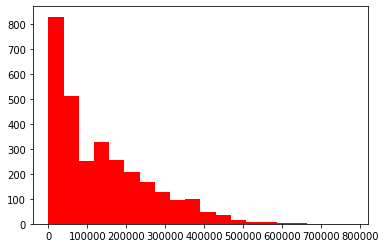

1:======================================================================
1
std_dev 0.49904776469013484
mean 1.5308436145381794
min 1
max 2


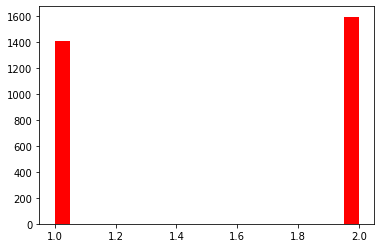

2:======================================================================
1_1
std_dev 0.8433425987110302
mean 1.924641547182394
min 0
max 6


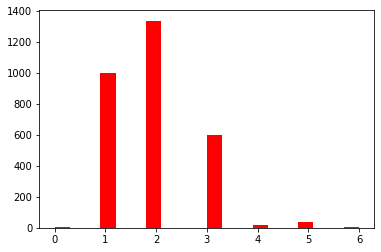

3:======================================================================
2
std_dev 0.5250735332196086
mean 1.517505835278426
min 0
max 3


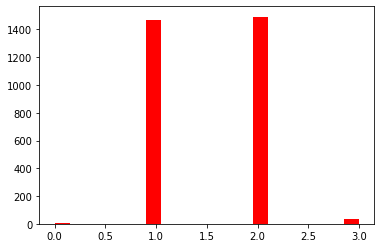

4:======================================================================
30
std_dev 9.051283128386304
mean 36.3187729243081
min 21
max 74


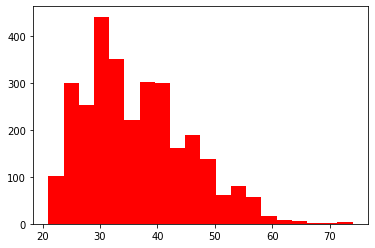

5:======================================================================
0
std_dev 1.134396062508122
mean -0.047349116372124044
min -2
max 7


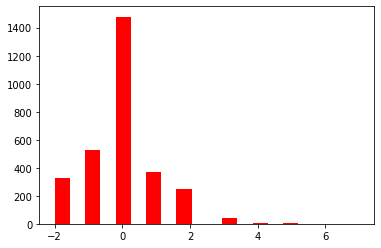

6:======================================================================
0_1
std_dev 1.2114492784593136
mean -0.1523841280426809
min -2
max 6


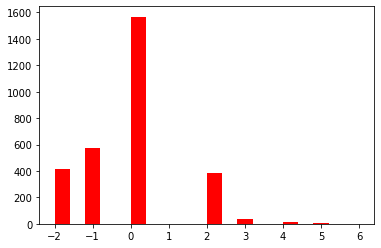

7:======================================================================
0_2
std_dev 1.1954924500894148
mean -0.18606202067355784
min -2
max 8


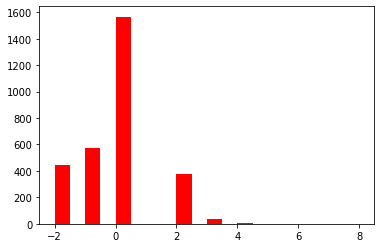

8:======================================================================
0_3
std_dev 1.2208077808226754
mean -0.2290763587862621
min -2
max 7


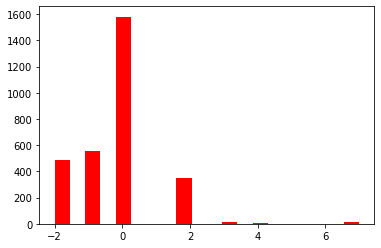

9:======================================================================
2_1
std_dev 1.1389385794260443
mean -0.3124374791597199
min -2
max 7


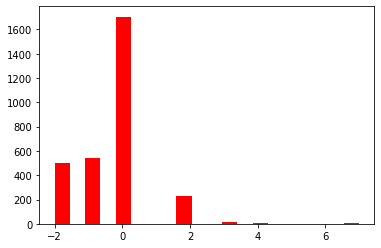

10:======================================================================
2_2
std_dev 1.152448480258947
mean -0.3401133711237079
min -2
max 7


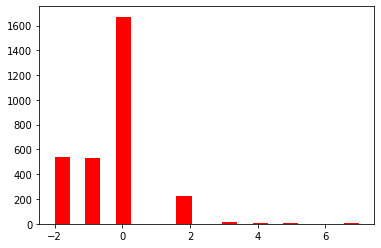

11:======================================================================
60290
std_dev 77655.92400009406
mean 52285.30943647883
min -11545
max 746814


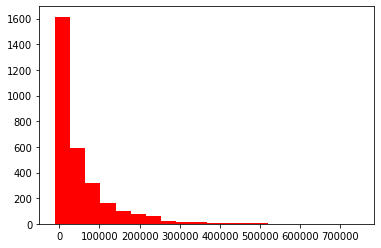

12:======================================================================
61688
std_dev 74233.25668941985
mean 50128.160053351115
min -17710
max 586825


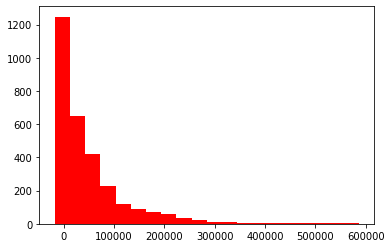

13:======================================================================
63100
std_dev 71816.46637447721
mean 47695.3747915972
min -46127
max 572677


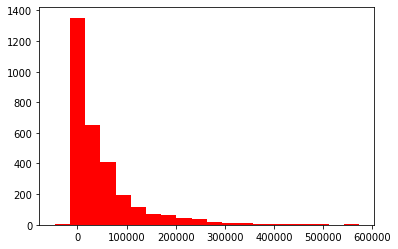

14:======================================================================
70391
std_dev 67021.89450145251
mean 44740.93397799267
min -50616
max 504929


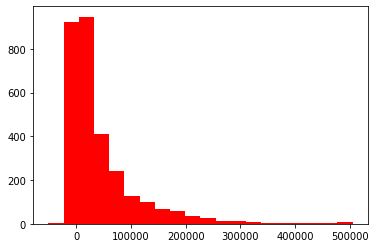

15:======================================================================
68661
std_dev 62106.41368546851
mean 40027.42047349116
min -53007
max 587067


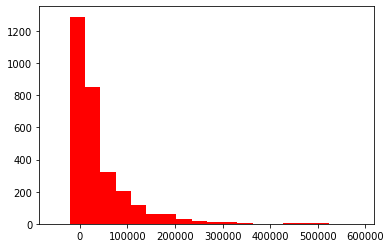

16:======================================================================
77511
std_dev 61444.509624354854
mean 38848.090696898966
min -94625
max 498316


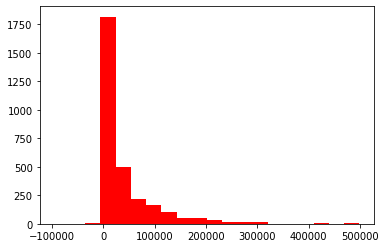

17:======================================================================
3000
std_dev 25979.825413278835
mean 6485.735911970657
min 0
max 873552


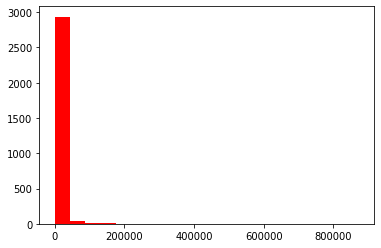

18:======================================================================
3000_1
std_dev 34723.901562645726
mean 6251.663887962654
min -1
max 1227082


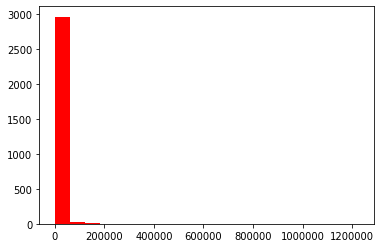

19:======================================================================
9000
std_dev 25446.466848978962
mean 6139.913304434812
min 0
max 889043


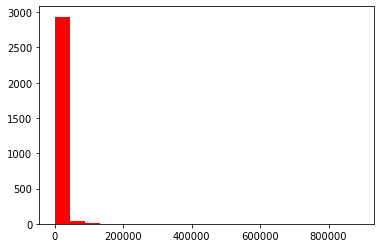

20:======================================================================
0_4
std_dev 18375.885752770613
mean 4950.0593531177055
min -1
max 621000


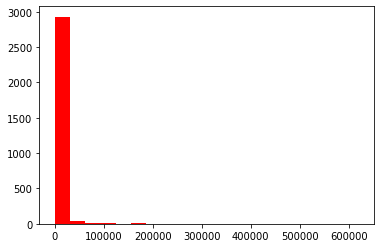

21:======================================================================
10000
std_dev 16938.782188174624
mean 4862.769923307769
min -1
max 426529


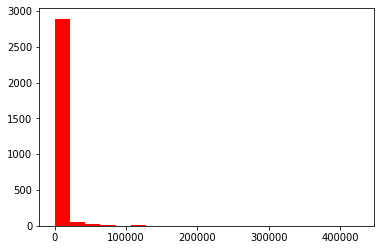

22:======================================================================
3000_2
std_dev 20076.446299281
mean 5556.758252750917
min -1
max 443001


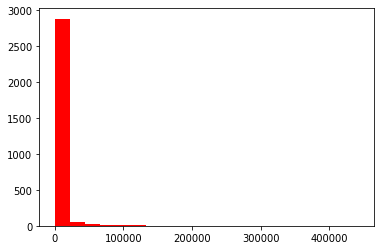

In [33]:
# Analyze
analyze(features, descriptions)

[[ 1. nan]
 [ 1. nan]
 [ 1. nan]
 ...
 [ 1. nan]
 [ 1. nan]
 [ 1. nan]] ['1', 'LOG(110000)']
0:======================================================================
1
std_dev 0.0
mean 1.0
min 1.0
max 1.0


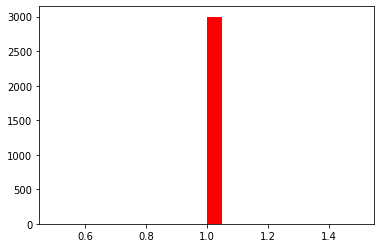

1:======================================================================
LOG(110000)
std_dev nan
mean nan
min nan
max nan


ValueError: autodetected range of [nan, nan] is not finite

In [34]:
analyze(nf, nd)


In [23]:
save_to_csv(nd, nf, correct_answers, 'ccard_preprocessed.csv')
print("ok")

ok


In [13]:
print(1 - np.mean(correct_answers))

0.7789263087695899


In [14]:
print(nf.shape)

(2999, 168)


In [15]:
print(np.max(nf[:, 1]))
print(np.min(nf[:, 1]))
f = (nf[:, 1] - np.min(nf[:, 1]))/(np.max(nf[:, 1]) - np.min(nf[:, 1]))
print(f)

1.0
0.0
[0.36941599185480056 0.15909880786929378 0.10788043175308164 ...
 0.2521656443822711  0.4772964236078822  0.36941599185480056]


In [16]:
correct_answers.astype(int)

array([0, 0, 0, ..., 1, 1, 1])